In [1]:
!pip install datasets
!pip install --upgrade jupyter ipywidgets



Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch, transformers
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from transformers import PreTrainedModel, PretrainedConfig
from transformers import AutoModel, AutoConfig

import torch.nn as nn
import torch.nn.functional as F
#from datasets import load_dataset
import pandas as pd, numpy as np
from torch import cuda
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import datetime
import warnings
from torch.optim.lr_scheduler import LambdaLR
# Ignore all warnings
warnings.filterwarnings('ignore')



In [3]:
#!nvidia-smi

In [4]:
#global params for training

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", padding = True, return_tensors = "pt",is_split_into_words=True)
batch_size = 32
epoch = 100
max_tokenizer_len = 512

# train_loss_list = []
# val_loss_list =[]
if cuda.is_available():
    device = torch.device('cuda:0')
    print(device)
else:
    device = 'cpu'
#print(device)
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
#os.environ["MKL_DEBUG_CPU_TYPE"] = "5"
glue_task = 'mrpc'
labels = ['Class 0', 'Class 1']
global_tr_loss = torch.inf
global_val_loss = torch.inf
#print(global_tr_loss)
model_path = os.path.join("data")
print(model_path)

cuda:0
data


In [5]:
from datasets import load_dataset
import pandas as pd, numpy as np

#pip install datasets

from datasets import load_dataset
#mrpc = load_dataset('glue', 'sst2')

dataset = load_dataset('glue','mrpc') 


In [6]:
#dataset
# msr_paraphrase_test.txt
# msr_paraphrase_train.txt
import pandas as pd , os
file_path = os.path.join("data","msr_paraphrase_train.txt")
print(file_path)

df = pd.read_csv(file_path,sep='\t', on_bad_lines='skip')
len(df)


data/msr_paraphrase_train.txt


3938

In [7]:
train_df_temp = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])


In [8]:
len(df_test)

1725

# Train Test split
    
    

In [9]:
seed = 42
# Randomly shuffle the DataFrame
df_shuffled = train_df_temp.sample(frac=1, random_state=seed)
train_ratio = 0.8
# Calculate the number of samples for training
train_size = int(train_ratio * len(df_shuffled))

# Split the shuffled DataFrame into training and testing sets
df_train = df_shuffled[:train_size]
df_val = df_shuffled[train_size:]


In [10]:
print(len(df_train))
print(len(df_val))

2934
734


In [11]:
df_train.head()

,sentence1,sentence2,label,idx
179,Tibco has used the Rendezvous name since 1994 ...,Tibco has used the Rendezvous name since 1994 ...,1,201
2679,Most of the alleged spammers engaged in fraudu...,""" Spam knows no borders , "" said Brad Smith , ...",0,2977
3133,"Yesterday , Taiwan reported 35 new infections ...",The island reported another 35 probable cases ...,1,3482
1061,"A month ago , the Commerce Department estimate...","A month ago , the Commerce Department said GDP...",1,1187
1091,Gillespie sent a letter to CBS President Lesli...,Republican National Committee Chairman Ed Gill...,0,1220


<AxesSubplot:xlabel='label', ylabel='count'>

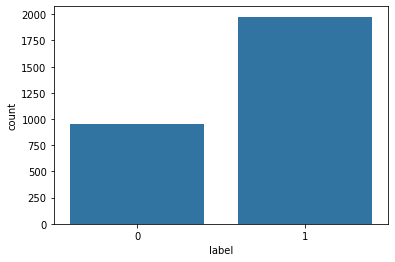

In [12]:
## Lets check the labal distributions
import seaborn as sns
sns.countplot(data = df_train ,x = df_train.label)

### This dataset is imbalanced, calculating weight adjustments to pass to the loss function

In [13]:
# get unique values for number of classes
num_classes = len(df_train.label.unique())
print(num_classes)
# get the number of samples for each class
class_dist = [0]*num_classes
print(class_dist)
# create a zero vector that equals the number of labels
for i in range(num_classes):
    class_dist[i]= (df_train['label']== i).sum()
print(class_dist)
class_dist = torch.tensor(class_dist)
print(type(class_dist))

2
[0, 0]
[957, 1977]
<class 'torch.Tensor'>


In [14]:
#label_0_wt = len(df_train) / (num_samples_in_class_i * num_classes)
weight_vector = torch.zeros(class_dist.shape)
for i in range(num_classes):
    weight_vector[i] = len(df_train) / (class_dist[i] * num_classes)
print(weight_vector)  

tensor([1.5329, 0.7420])


In [15]:
# Test the tokenizer:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", padding = True, return_tensors = "pt" , truncate = True, max_length  = 512)

#encoding multiple sentences with a tokenizer https://discuss.huggingface.co/t/use-two-sentences-as-inputs-for-sentence-classification/5444/3

encoding = tokenizer(df_train['sentence1'][9], df_train['sentence2'][9] , padding="max_length", truncation=True)



In [16]:
encoding

{'input_ids': [101, 6661, 1997, 4962, 10111, 2818, 1010, 1037, 2172, 3469, 2194, 2007, 2195, 3688, 2006, 1996, 3006, 1010, 3123, 2062, 2084, 1016, 3867, 1012, 102, 6661, 1997, 1060, 9626, 3062, 2385, 3867, 1999, 2220, 3119, 1010, 2096, 6661, 1997, 4962, 10111, 2818, 1010, 1037, 2172, 3469, 2194, 2007, 2195, 3688, 2006, 1996, 3006, 1010, 2020, 2039, 1016, 3867, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Data loaders and Dataset for batched training

In [17]:
class dataset_pyt(Dataset):
    def __init__(self, df):
        self.df = df
        self.num_classes = len(df.label.unique())
                
    def __getitem__(self, idx):
        text1 = self.df.iloc[idx]['sentence1']
        text2 = self.df.iloc[idx]['sentence2']
        x = tokenizer(text1,text2 ,padding="max_length",truncation=True, return_tensors="pt" )
        #print(f"inside the loader and index = {idx}")
        x_dict = {}
        x_dict['id'] = x['input_ids']
        x_dict['token_type'] = x['token_type_ids']
        x_dict['attention_mask'] = x['attention_mask']
        #label = torch.tensor(self.df.iloc[idx]['label'] , dtype=torch.float32)
        label_onehot = torch.nn.functional.one_hot(torch.tensor(self.df.iloc[idx]['label']), num_classes= num_classes).float()
        
        #print(f"inside the dataset class ..label_vec_t = {label_onehot}")
        return x_dict, label_onehot
        
    def __len__(self):
        #return the length of the dataframe
        return len(self.df)
    

In [18]:
train_dataset = dataset_pyt(df_train)
val_dataset = dataset_pyt(df_val)
test_dataset = dataset_pyt(df_test)

train_loader = DataLoader(train_dataset,batch_size = batch_size, shuffle = True , num_workers = 0, pin_memory = False)
val_loader = DataLoader(val_dataset,batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset,batch_size = batch_size, shuffle = False)

    

### Training the model

In [19]:
# class clf_model(torch.nn.Module):
#     def __init__(self):
#         super(clf_model, self).__init__()
#         self.backbone = transformers.BertModel.from_pretrained('bert-base-cased')
#         #self.norm_layer = torch.nn.LayerNorm()
#         self.linear_layer = torch.nn.Linear(768, 2)
         
                  
#     def forward(self,ids ,token_type,att_mask):
#         #print(f"shape of ids->{ids.shape}")
#            #ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False     
#         _,x = self.backbone(ids , token_type_ids =token_type ,attention_mask= att_mask, return_dict=False)
                
#         x = self.linear_layer(x)
#         #print(f"shape after linear_layer->{x.shape}")
#         #print(f"x after linear ->{x}")
#         #layer_norm = torch.nn.LayerNorm(x.shape[1])
#         #x = layer_norm(x)
#         #print(f"x fter layer norm = {x}")
#         return x

In [20]:
#self.l2 = torch.nn.Dropout(0.3)
class clf_model_drp(torch.nn.Module):
    def __init__(self):
        super(clf_model_drp, self).__init__()
        self.backbone = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.dropout = torch.nn.Dropout(0.8)
        self.linear_layer = torch.nn.Linear(768, 2)
         
                  
    def forward(self,ids ,token_type,att_mask):
        #print(f"shape of ids->{ids.shape}")
           #ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False     
        _,x = self.backbone(ids , token_type_ids =token_type ,attention_mask= att_mask, return_dict=False)
        x = self.dropout(x)
        x = self.linear_layer(x)
        #print(f"shape after linear_layer->{x.shape}")
        #print(f"x after linear ->{x}")
        #layer_norm = torch.nn.LayerNorm(x.shape[1])
        #x = layer_norm(x)
        #print(f"x fter layer norm = {x}")
        return x


In [21]:
#https://stackoverflow.com/questions/73948214/how-to-convert-a-pytorch-nn-module-into-a-huggingface-pretrainedmodel-object/74109727#74109727
# this code is needed to save the HF model as pre-trained and use this model as inference
class MyConfig(PretrainedConfig):
    model_type = 'mymodel'
    def __init__(self, important_param=42, **kwargs):
        super().__init__(**kwargs)
        self.important_param = important_param

class MyModel(PreTrainedModel):
    config_class = MyConfig
    def __init__(self, config):
        super().__init__(config)
        self.config = config
        self.model = clf_model_drp()
    def forward(self, ids ,token_type,att_mask):
        return self.model(ids ,token_type,att_mask) 

In [22]:
def plot_confusion_matrix(y_true,y_pred, labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font scale for better readability
    conf_mat = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()



In [23]:
@torch.no_grad
def eval_model(val_loader, model, epoch , device = device,):
    global global_val_loss
    m = nn.Softmax()
    model.eval()
    model.to(device)
    e = epoch+1
    val_loss_list = []
    criterion = torch.nn.BCEWithLogitsLoss()
    print(f"inside validation data for epoch {e}")
    y_hat_val_list = []
    y_val_list = []
    for ind,(x_dict, label_vec) in enumerate(val_loader):
        model.to(device)
        id_list = x_dict['id']
        ids = torch.squeeze(torch.tensor(id_list, device = device),dim = 1).clone().detach()
        tok_type_list = x_dict['token_type']
        token_type = torch.squeeze(torch.tensor(tok_type_list, device = device),dim = 1).clone().detach()
        att_list = x_dict['attention_mask']
        att_mask = torch.squeeze(torch.tensor(att_list, device = device),dim = 1).clone().detach()
        lab = label_vec.to(torch.device('cuda:0'))
        logits = model(ids ,token_type,att_mask)
        
        probs = m(logits)
        y_hat_val_list.append(torch.argmax(probs , dim = 1))
        y_val_list.append(torch.argmax(lab , dim = 1))
        
        act_loss = criterion(logits, lab)
        val_loss_list.append(act_loss.item())
            
    mean_val_loss = torch.mean(torch.tensor(val_loss_list))
    if mean_val_loss < global_val_loss:
        print(f"Val loss has decreased -->reducing the global validation loss from {global_val_loss:.2f} to {mean_val_loss:.2f}")
        global_val_loss = mean_val_loss
        print(f" validation loss for epoch = {e} is {torch.mean(torch.tensor(val_loss_list)):.4f}")
        #print metrics and save the model
        y_hat_val = torch.cat(y_hat_val_list)
        y_val = torch.cat(y_val_list)
        acc_val = accuracy_score(y_val.cpu().numpy(), y_hat_val.cpu().numpy())
        f1_val = f1_score(y_val.cpu().numpy(), y_hat_val.cpu().numpy(), average='micro')
        print(f" epoch= {e} : mean val loss is {torch.mean(torch.tensor(mean_val_loss)):.4f} -> the accuracy is {acc_val:.2f} ->the f1 is {f1_val:.2f} ")
        #save the model
        
        # Get the current date and time
        current_datetime = datetime.datetime.now()
        # Extract date and time components
        current_date = str(current_datetime.date())
        current_time = str(current_datetime.time()).split('.')[0]
        file_name = 'model'+ current_date+current_time+'_'+glue_task+'.pth'
        path = os.path.join("model",file_name)
        print(f"saving the model {file_name}")
        #torch.save(model.state_dict(), path)
        model.save_pretrained(path)
        
        plot_confusion_matrix(y_val.cpu().numpy(), y_hat_val.cpu().numpy(), labels)
    else:
        print(f"No improvement in validation loss-->epoch= {e} and global val loss is {global_val_loss:.4f}")
        
    
    
    
      

In [24]:
def train_model(train_loader,val_loader,model,num_epoch = 5,device = device, class_weights = weight_vector):
    global global_tr_loss
    model.train()
    device = device
    print(f"inside train model. Device = {device}")
    optimizer = torch.optim.AdamW(params =  model.parameters(), lr= 2e-5)
    model.to(device)
    wt = class_weights.to(device = device)
    m = nn.Softmax()
    criterion = torch.nn.BCEWithLogitsLoss(weight = wt)
    from transformers import get_linear_schedule_with_warmup
    scheduler = transformers.get_cosine_schedule_with_warmup( optimizer= optimizer, num_warmup_steps =len(train_loader)*num_epoch*.1 ,num_training_steps= len(train_loader)*num_epoch,last_epoch = -1 )
    
    for i in range (num_epoch):
        y_hat_list =[]
        label_list = []
        epoch_train_loss = []
        for ind,(x_dict, label_vec) in enumerate(train_loader):
            id_list = x_dict['id']
            ids = torch.squeeze(torch.tensor(id_list, device = device),dim = 1).clone().detach()
            tok_type_list = x_dict['token_type']
            token_type = torch.squeeze(torch.tensor(tok_type_list, device = device),dim = 1).clone().detach()
            att_list = x_dict['attention_mask']
            att_mask = torch.squeeze(torch.tensor(att_list, device = device),dim = 1).clone().detach()
            lab = label_vec.to(device = device)
            #predictions
            logits = model(ids ,token_type,att_mask)
            probs = m(logits)
            y_hat_list.append(torch.argmax(probs , dim = 1))
            label_list.append(torch.argmax(lab, dim = 1))
            
            #loss calculation                   
            act_loss = criterion(logits, lab)
            epoch_train_loss.append(act_loss.item())
            optimizer.zero_grad(set_to_none=True)
            act_loss.backward()
            optimizer.step()
            #print(f"current LR->{scheduler.get_last_lr()}")
            scheduler.step()
            #print(f"POST SCHEDULER.step LR->{scheduler.get_last_lr()}")
            
        #batch processing complete    
        mean_loss = torch.mean(torch.tensor(epoch_train_loss))
        
        if mean_loss < global_tr_loss:
            print(f"training loss has decreased---> reducing the global loss from {global_tr_loss:.2f} to {mean_loss:.2f}")
            global_tr_loss = mean_loss
            print(f" epoch= {i+1} and mean train loss is {torch.mean(torch.tensor(epoch_train_loss)):.4f}")
            #printing training metrices
            y_hat = torch.cat(y_hat_list)
            y = torch.cat(label_list)
            acc = accuracy_score(y.cpu().numpy(), y_hat.cpu().numpy())
            f1 = f1_score(y.cpu().numpy(), y_hat.cpu().numpy(), average='micro')
            print(f" epoch= {i+1} : mean train loss is {torch.mean(torch.tensor(epoch_train_loss)):.4f} -> the accuracy is {acc:.2f} ->the f1 is {f1:.2f} ")
            #checking validation metrices
            eval_model(val_loader, model, epoch = i , device = device)
            
        else:
            print(f"No improvement in training loss..the global training loss is -->{global_tr_loss:.2f} ")
            print(f" epoch= {i+1} and mean train loss is {torch.mean(torch.tensor(epoch_train_loss)):.4f}")
        
        
    
    return model
        
            
            
    
    

inside train model. Device = cuda:0
training loss has decreased---> reducing the global loss from inf to 0.77
 epoch= 1 and mean train loss is 0.7747
 epoch= 1 : mean train loss is 0.7747 -> the accuracy is 0.65 ->the f1 is 0.65 
inside validation data for epoch 1
Val loss has decreased -->reducing the global validation loss from inf to 0.55
 validation loss for epoch = 1 is 0.5516
 epoch= 1 : mean val loss is 0.5516 -> the accuracy is 0.72 ->the f1 is 0.72 
saving the model model2024-05-1712:17:30_mrpc.pth


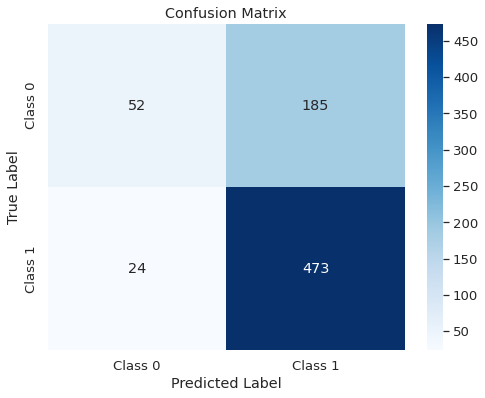

training loss has decreased---> reducing the global loss from 0.77 to 0.56
 epoch= 2 and mean train loss is 0.5632
 epoch= 2 : mean train loss is 0.5632 -> the accuracy is 0.76 ->the f1 is 0.76 
inside validation data for epoch 2
Val loss has decreased -->reducing the global validation loss from 0.55 to 0.46
 validation loss for epoch = 2 is 0.4612
 epoch= 2 : mean val loss is 0.4612 -> the accuracy is 0.78 ->the f1 is 0.78 
saving the model model2024-05-1712:18:47_mrpc.pth


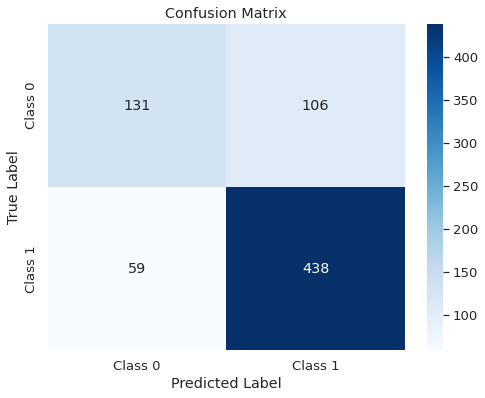

training loss has decreased---> reducing the global loss from 0.56 to 0.32
 epoch= 3 and mean train loss is 0.3164
 epoch= 3 : mean train loss is 0.3164 -> the accuracy is 0.90 ->the f1 is 0.90 
inside validation data for epoch 3
Val loss has decreased -->reducing the global validation loss from 0.46 to 0.44
 validation loss for epoch = 3 is 0.4445
 epoch= 3 : mean val loss is 0.4445 -> the accuracy is 0.79 ->the f1 is 0.79 
saving the model model2024-05-1712:20:05_mrpc.pth


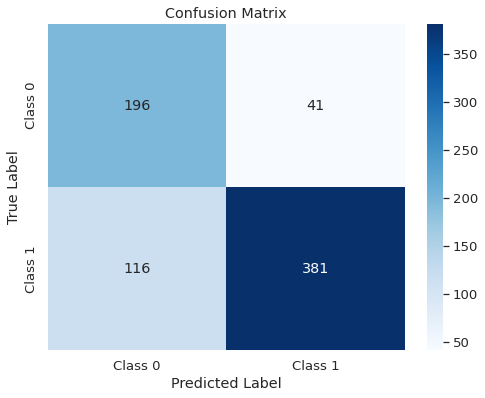

training loss has decreased---> reducing the global loss from 0.32 to 0.15
 epoch= 4 and mean train loss is 0.1498
 epoch= 4 : mean train loss is 0.1498 -> the accuracy is 0.97 ->the f1 is 0.97 
inside validation data for epoch 4
No improvement in validation loss-->epoch= 4 and global val loss is 0.4445


KeyboardInterrupt: 

In [25]:
config = MyConfig(42)
model = MyModel(config)

#train_loader,optimizer,val_loader ,num_epoch = 100, model = clf_model()
tr_model = train_model(train_loader, val_loader, model =  model)

### Evaluating the models on test data

In [25]:
def final_pred(loader, model, device = device,):
    m = nn.Softmax()
    model.eval()
    model.to(device)
    test_loss_list = []
    criterion = torch.nn.BCEWithLogitsLoss()
    y_hat_test_list = []
    y_test_list = []
    for ind,(x_dict, label_vec) in enumerate(loader):
        model.to(device)
        id_list = x_dict['id']
        ids = torch.squeeze(torch.tensor(id_list, device = device),dim = 1).clone().detach()
        tok_type_list = x_dict['token_type']
        token_type = torch.squeeze(torch.tensor(tok_type_list, device = device),dim = 1).clone().detach()
        att_list = x_dict['attention_mask']
        att_mask = torch.squeeze(torch.tensor(att_list, device = device),dim = 1).clone().detach()
        lab = label_vec.to(torch.device('cuda:0'))
        logits = model(ids ,token_type,att_mask)
        
        probs = m(logits)
        y_hat_test_list.append(torch.argmax(probs , dim = 1))
        y_test_list.append(torch.argmax(lab , dim = 1))
        
        act_loss = criterion(logits, lab)
        test_loss_list.append(act_loss.item())
            
    mean_test_loss = torch.mean(torch.tensor(test_loss_list))
    print(f" Test loss is {torch.mean(torch.tensor(test_loss_list)):.4f}")
    #print metrics and save the model
    y_hat_test = torch.cat(y_hat_test_list)
    y_test = torch.cat(y_test_list)
    acc_test = accuracy_score(y_test.cpu().numpy(), y_hat_test.cpu().numpy())
    f1_test = f1_score(y_test.cpu().numpy(), y_hat_test.cpu().numpy(), average='micro')
    print(f"mean loss is {torch.mean(torch.tensor(mean_test_loss)):.4f} -> the accuracy is {acc_test:.2f} ->the f1 is {f1_test:.2f} ")
    #save the model
    plot_confusion_matrix(y_test.cpu().numpy(), y_hat_test.cpu().numpy(), labels)

   
        


In [26]:
saved_model = MyModel.from_pretrained('./model/model2024-05-1712:14:28_mrpc.pth')


 Test loss is 0.4482
mean loss is 0.4482 -> the accuracy is 0.79 ->the f1 is 0.79 


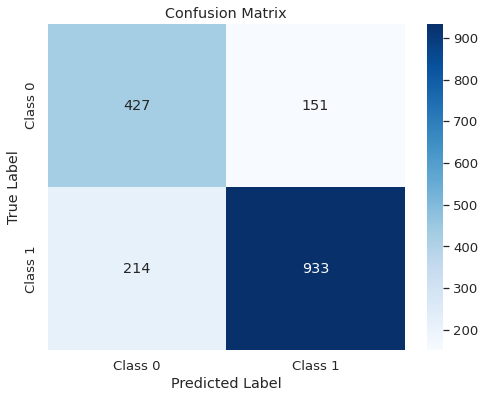

In [27]:
final_pred(test_loader , saved_model )